# **Deep Learning: Classification of tweets in English using BERT and profanity-check**

> **BERT uncased pretrained model: https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1** <br>
> **Profanity-check: https://github.com/vzhou842/profanity-check**

In this notebook we face a **binary text classification** problem to determinate if a Twitter user is a hate spreader or not. The possible labels in this case are **0 (not hate spreader)** or **1 (hate spreader)**.

The dataset used thoughout this code is available here: https://zenodo.org/record/4603578#.YMvUWmgzZPY

# **Load dependencies**

In [ ]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
!pip install sentencepiece

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from sklearn import model_selection
from sklearn import metrics
import keras

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import tokenization
import os

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Check if GPU is working

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.gpu_device_name()

Num GPUs Available:  1


'/device:GPU:0'

# **Load data**

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive/")
!ls 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
drive	  __pycache__  tokenization.py	  tokenization.py.2
model.h5  sample_data  tokenization.py.1  tokenization.py.3


Load the Author Profiling dataset from Google Drive path. This folder contais a total of 200 `xml` files in English and 200 `xml` files in Spanish, each one of them corresponding to an author (user of Twitter). Every file contains in turn 200 tweets of that user profile. What we are doing in this step, is to collect all this information into a single dataframe, with every row per author and two basic columns:


*   *label*: **0** if the author is not classified as hate spreader or **1** if it is.
*   *tweets*: This is a concatenation of all the 200 tweets of a single author into a text.





In [ ]:
# Home path where text file is stored
home_path = 'drive/My Drive/Colab Notebooks/Dataset/pan21-author-profiling-training-2021-03-14/'

# Text file to read
language = 'en'
data_files = home_path + language

In [ ]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# Dataframe to collect all the authors, their label and their tweets
df_cols = ['author', 'label', 'tweets']
df = pd.DataFrame(columns = df_cols)

# Read all the xml files
for filename in os.listdir(data_files):
  if not filename.endswith('.xml'): continue
  fullname = os.path.join(data_files, filename)
  root = ET.parse(fullname).getroot()
  author = filename.replace('.xml','') # Get author from the filename
  label = root.attrib.get("class") # Get class/label of that author
  tweets = ""
  for docs in root:
    for tweet in docs:
      tweets = tweets + " " + tweet.text # Combine all tweets of the same author
  df = df.append({'author': author, 'label': label, 'tweets': tweets}, ignore_index=True) # Add the author, its label and its tweets to the dataframe

df

,author,label,tweets
0,4d4c5dcbfe38d0d33a0d1b1419952ca8,0,#USER# None at all. Just the ability to lie a...
1,e30577895cbb4d8f073e4dbb2f3be6d1,0,"Still at work, sleepy asf...tryna figure out ..."
2,9d08913250938aadcf6c18d0c89a0d14,0,I walk in kangaroo made eye contact with this...
3,86a7f84c2dd126dac46270b6c912952c,0,Who wants this acc And to all the people who ...
4,2a9776a2909ba5e27043faf2d57ba410,0,RT #USER#: Attack on the titans if Bollywood ...
...,...,...,...
195,46df8a13b82d12b2d5f453cc63612298,1,RT #USER#: : 😭 ... #USER# #USER# #USER# thee ...
196,342a27905d2291b55486c257d77265b4,1,#USER# Making a profit off their dead relativ...
197,f00627537c48b43bf2045b98b3508d94,1,Biden's Feed Cuts Out After Saying 'He Will T...
198,e5cc453c1de4371b8d668c3ab50126f1,1,World-Wide GIVEAWAY! Enter for a chance to wi...


In [ ]:
# Keep a copy of the original dataset without any modification
df_original = df.copy(deep = True)

# **Clean tweets**

In this section we are doing a preprocessing of all the texts in order to simplify the lexicon and remove symbols, characters or words which do not provide any information.
The steps perfomed are the following:
*   Convert all the text to **lower-case**.
*   Remove **urls**, **punctuation marks**, **emojis**, **symbols**, and **flags** between others.
*   Remove **stopwords** such as prepositions, articles or pronouns.
*   **Stemming** to reduce every word to its root form (*for example: walking → walk*).
*   Remove **words with less than 3 characters**, **numbers** or **digits**.





In [ ]:
import nltk
import re
import string
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Select list of stopwords depending on the language
select_language = {
    'en': stopwords.words("english") + ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fify', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 'further', 'get', 'got', 'give', 'go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed', 'interest', 'into', 'is', 'it', 'its', 'itself', 'keep', 'last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made', 'many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine', 'more', 'moreover', 'most', 'mostly', 'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'never', 'nevertheless', 'next', 'nine', 'no', 'nobody', 'none', 'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'once', 'one', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'part', 'per', 'perhaps', 'please', 'put', 'rather', 're', 'same', 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 'several', 'she', 'should', 'show', 'side', 'since', 'sincere', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 'still', 'such', 'system', 'take', 'ten', 'than', 'that', 'the', 'their', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'thereupon', 'these', 'they', 'thick', 'thin', 'third', 'this', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'un', 'under', 'until', 'up', 'upon', 'us', 'very', 'via', 'was', 'we', 'well', 'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with', 'within', 'without', 'would', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves'], 
    'es': stopwords.words("spanish")
}
stopwords_list = select_language.get(language) + ['user', 'rt', 'url', 'hashtag']

In [ ]:
def clean_tweets(text):
  text = str(text).lower() # Text to lower-case

  # Remove urls, emojis, symbols...
  url = re.compile(r'https?://\S+|www\.\S+')
  html = re.compile(r'<.*?>')
  emoji_pattern = re.compile("["u"\U0001F1E6"u"\U0001F1E7"u"\U0001F1E8"u"\U0001F1E9"u"\U0001F1EA"u"\U0001F1EB"u"\U0001F1EC"u"\U0001F1ED"u"\U0001F1EE"u"\U0001F1EF"u"\U0001F1F0"u"\U0001F1F1"u"\U0001F1F2"u"\U0001F1F3"u"\U0001F1F4"u"\U0001F1F5"u"\U0001F1F6"u"\U0001F1F7"u"\U0001F1F8"u"\U0001F1F9"u"\U0001F1FA"u"\U0001F1FB"u"\U0001F1FC"u"\U0001F1FD"u"\U0001F1FE"u"\U0001F1FF"u"\U0001F201"u"\U0001F202"u"\U0001F21A"u"\U0001F22F"u"\U0001F232"u"\U0001F233"u"\U0001F234"u"\U0001F235"u"\U0001F236"u"\U0001F237"u"\U0001F238"u"\U0001F239"u"\U0001F23A"u"\U0001F250"u"\U0001F251"u"\U0001F300"u"\U0001F301"u"\U0001F302"u"\U0001F303"u"\U0001F304"u"\U0001F305"u"\U0001F306"u"\U0001F307"u"\U0001F308"u"\U0001F309"u"\U0001F30A"u"\U0001F30B"u"\U0001F30C"u"\U0001F30D"u"\U0001F30E"u"\U0001F30F"u"\U0001F310"u"\U0001F311"u"\U0001F312"u"\U0001F313"u"\U0001F314"u"\U0001F315"u"\U0001F316"u"\U0001F317"u"\U0001F318"u"\U0001F319"u"\U0001F31A"u"\U0001F31B"u"\U0001F31C"u"\U0001F31D"u"\U0001F31E"u"\U0001F31F"u"\U0001F320"u"\U0001F321"u"\U0001F324"u"\U0001F325"u"\U0001F326"u"\U0001F327"u"\U0001F328"u"\U0001F329"u"\U0001F32A"u"\U0001F32B"u"\U0001F32C"u"\U0001F32D"u"\U0001F32E"u"\U0001F32F"u"\U0001F330"u"\U0001F331"u"\U0001F332"u"\U0001F333"u"\U0001F334"u"\U0001F335"u"\U0001F336"u"\U0001F337"u"\U0001F338"u"\U0001F339"u"\U0001F33A"u"\U0001F33B"u"\U0001F33C"u"\U0001F33D"u"\U0001F33E"u"\U0001F33F"u"\U0001F340"u"\U0001F341"u"\U0001F342"u"\U0001F343"u"\U0001F344"u"\U0001F345"u"\U0001F346"u"\U0001F347"u"\U0001F348"u"\U0001F349"u"\U0001F34A"u"\U0001F34B"u"\U0001F34C"u"\U0001F34D"u"\U0001F34E"u"\U0001F34F"u"\U0001F350"u"\U0001F351"u"\U0001F352"u"\U0001F353"u"\U0001F354"u"\U0001F355"u"\U0001F356"u"\U0001F357"u"\U0001F358"u"\U0001F359"u"\U0001F35A"u"\U0001F35B"u"\U0001F35C"u"\U0001F35D"u"\U0001F35E"u"\U0001F35F"u"\U0001F360"u"\U0001F361"u"\U0001F362"u"\U0001F363"u"\U0001F364"u"\U0001F365"u"\U0001F366"u"\U0001F367"u"\U0001F368"u"\U0001F369"u"\U0001F36A"u"\U0001F36B"u"\U0001F36C"u"\U0001F36D"u"\U0001F36E"u"\U0001F36F"u"\U0001F370"u"\U0001F371"u"\U0001F372"u"\U0001F373"u"\U0001F374"u"\U0001F375"u"\U0001F376"u"\U0001F377"u"\U0001F378"u"\U0001F379"u"\U0001F37A"u"\U0001F37B"u"\U0001F37C"u"\U0001F37D"u"\U0001F37E"u"\U0001F37F"u"\U0001F380"u"\U0001F381"u"\U0001F382"u"\U0001F383"u"\U0001F384"u"\U0001F385"u"\U0001F386"u"\U0001F387"u"\U0001F388"u"\U0001F389"u"\U0001F38A"u"\U0001F38B"u"\U0001F38C"u"\U0001F38D"u"\U0001F38E"u"\U0001F38F"u"\U0001F390"u"\U0001F391"u"\U0001F392"u"\U0001F393"u"\U0001F396"u"\U0001F397"u"\U0001F399"u"\U0001F39A"u"\U0001F39B"u"\U0001F39E"u"\U0001F39F"u"\U0001F3A0"u"\U0001F3A1"u"\U0001F3A2"u"\U0001F3A3"u"\U0001F3A4"u"\U0001F3A5"u"\U0001F3A6"u"\U0001F3A7"u"\U0001F3A8"u"\U0001F3A9"u"\U0001F3AA"u"\U0001F3AB"u"\U0001F3AC"u"\U0001F3AD"u"\U0001F3AE"u"\U0001F3AF"u"\U0001F3B0"u"\U0001F3B1"u"\U0001F3B2"u"\U0001F3B3"u"\U0001F3B4"u"\U0001F3B5"u"\U0001F3B6"u"\U0001F3B7"u"\U0001F3B8"u"\U0001F3B9"u"\U0001F3BA"u"\U0001F3BB"u"\U0001F3BC"u"\U0001F3BD"u"\U0001F3BE"u"\U0001F3BF"u"\U0001F3C0"u"\U0001F3C1"u"\U0001F3C2"u"\U0001F3C3"u"\U0001F3C4"u"\U0001F3C5"u"\U0001F3C6"u"\U0001F3C7"u"\U0001F3C8"u"\U0001F3C9"u"\U0001F3CA"u"\U0001F3CB"u"\U0001F3CC"u"\U0001F3CD"u"\U0001F3CE"u"\U0001F3CF"u"\U0001F3D0"u"\U0001F3D1"u"\U0001F3D2"u"\U0001F3D3"u"\U0001F3D4"u"\U0001F3D5"u"\U0001F3D6"u"\U0001F3D7"u"\U0001F3D8"u"\U0001F3D9"u"\U0001F3DA"u"\U0001F3DB"u"\U0001F3DC"u"\U0001F3DD"u"\U0001F3DE"u"\U0001F3DF"u"\U0001F3E0"u"\U0001F3E1"u"\U0001F3E2"u"\U0001F3E3"u"\U0001F3E4"u"\U0001F3E5"u"\U0001F3E6"u"\U0001F3E7"u"\U0001F3E8"u"\U0001F3E9"u"\U0001F3EA"u"\U0001F3EB"u"\U0001F3EC"u"\U0001F3ED"u"\U0001F3EE"u"\U0001F3EF"u"\U0001F3F0"u"\U0001F3F3"u"\U0001F3F4"u"\U0001F3F5"u"\U0001F3F7"u"\U0001F3F8"u"\U0001F3F9"u"\U0001F3FA"u"\U0001F400"u"\U0001F401"u"\U0001F402"u"\U0001F403"u"\U0001F404"u"\U0001F405"u"\U0001F406"u"\U0001F407"u"\U0001F408"u"\U0001F409"u"\U0001F40A"u"\U0001F40B"u"\U0001F40C"u"\U0001F40D"u"\U0001F40E"u"\U0001F40F"u"\U0001F410"u"\U0001F411"u"\U0001F412"u"\U0001F413"u"\U0001F414"u"\U0001F415"u"\U0001F416"u"\U0001F417"u"\U0001F418"u"\U0001F419"u"\U0001F41A"u"\U0001F41B"u"\U0001F41C"u"\U0001F41D"u"\U0001F41E"u"\U0001F41F"u"\U0001F420"u"\U0001F421"u"\U0001F422"u"\U0001F423"u"\U0001F424"u"\U0001F425"u"\U0001F426"u"\U0001F427"u"\U0001F428"u"\U0001F429"u"\U0001F42A"u"\U0001F42B"u"\U0001F42C"u"\U0001F42D"u"\U0001F42E"u"\U0001F42F"u"\U0001F430"u"\U0001F431"u"\U0001F432"u"\U0001F433"u"\U0001F434"u"\U0001F435"u"\U0001F436"u"\U0001F437"u"\U0001F438"u"\U0001F439"u"\U0001F43A"u"\U0001F43B"u"\U0001F43C"u"\U0001F43D"u"\U0001F43E"u"\U0001F43F"u"\U0001F440"u"\U0001F441"u"\U0001F442"u"\U0001F443"u"\U0001F444"u"\U0001F445"u"\U0001F446"u"\U0001F447"u"\U0001F448"u"\U0001F449"u"\U0001F44A"u"\U0001F44B"u"\U0001F44C"u"\U0001F44D"u"\U0001F44E"u"\U0001F44F"u"\U0001F450"u"\U0001F451"u"\U0001F452"u"\U0001F453"u"\U0001F454"u"\U0001F455"u"\U0001F456"u"\U0001F457"u"\U0001F458"u"\U0001F459"u"\U0001F45A"u"\U0001F45B"u"\U0001F45C"u"\U0001F45D"u"\U0001F45E"u"\U0001F45F"u"\U0001F460"u"\U0001F461"u"\U0001F462"u"\U0001F463"u"\U0001F464"u"\U0001F465"u"\U0001F466"u"\U0001F467"u"\U0001F468"u"\U0001F469"u"\U0001F46A"u"\U0001F46B"u"\U0001F46C"u"\U0001F46D"u"\U0001F46E"u"\U0001F46F"u"\U0001F470"u"\U0001F471"u"\U0001F472"u"\U0001F473"u"\U0001F474"u"\U0001F475"u"\U0001F476"u"\U0001F477"u"\U0001F478"u"\U0001F479"u"\U0001F47A"u"\U0001F47B"u"\U0001F47C"u"\U0001F47D"u"\U0001F47E"u"\U0001F47F"u"\U0001F480"u"\U0001F481"u"\U0001F482"u"\U0001F483"u"\U0001F484"u"\U0001F485"u"\U0001F486"u"\U0001F487"u"\U0001F488"u"\U0001F489"u"\U0001F48A"u"\U0001F48B"u"\U0001F48C"u"\U0001F48D"u"\U0001F48E"u"\U0001F48F"u"\U0001F490"u"\U0001F491"u"\U0001F492"u"\U0001F493"u"\U0001F494"u"\U0001F495"u"\U0001F496"u"\U0001F497"u"\U0001F498"u"\U0001F499"u"\U0001F49A"u"\U0001F49B"u"\U0001F49C"u"\U0001F49D"u"\U0001F49E"u"\U0001F49F"u"\U0001F4A0"u"\U0001F4A1"u"\U0001F4A2"u"\U0001F4A3"u"\U0001F4A4"u"\U0001F4A5"u"\U0001F4A6"u"\U0001F4A7"u"\U0001F4A8"u"\U0001F4A9"u"\U0001F4AA"u"\U0001F4AB"u"\U0001F4AC"u"\U0001F4AD"u"\U0001F4AE"u"\U0001F4AF"u"\U0001F4B0"u"\U0001F4B1"u"\U0001F4B2"u"\U0001F4B3"u"\U0001F4B4"u"\U0001F4B5"u"\U0001F4B6"u"\U0001F4B7"u"\U0001F4B8"u"\U0001F4B9"u"\U0001F4BA"u"\U0001F4BB"u"\U0001F4BC"u"\U0001F4BD"u"\U0001F4BE"u"\U0001F4BF"u"\U0001F4C0"u"\U0001F4C1"u"\U0001F4C2"u"\U0001F4C3"u"\U0001F4C4"u"\U0001F4C5"u"\U0001F4C6"u"\U0001F4C7"u"\U0001F4C8"u"\U0001F4C9"u"\U0001F4CA"u"\U0001F4CB"u"\U0001F4CC"u"\U0001F4CD"u"\U0001F4CE"u"\U0001F4CF"u"\U0001F4D0"u"\U0001F4D1"u"\U0001F4D2"u"\U0001F4D3"u"\U0001F4D4"u"\U0001F4D5"u"\U0001F4D6"u"\U0001F4D7"u"\U0001F4D8"u"\U0001F4D9"u"\U0001F4DA"u"\U0001F4DB"u"\U0001F4DC"u"\U0001F4DD"u"\U0001F4DE"u"\U0001F4DF"u"\U0001F4E0"u"\U0001F4E1"u"\U0001F4E2"u"\U0001F4E3"u"\U0001F4E4"u"\U0001F4E5"u"\U0001F4E6"u"\U0001F4E7"u"\U0001F4E8"u"\U0001F4E9"u"\U0001F4EA"u"\U0001F4EB"u"\U0001F4EC"u"\U0001F4ED"u"\U0001F4EE"u"\U0001F4EF"u"\U0001F4F0"u"\U0001F4F1"u"\U0001F4F2"u"\U0001F4F3"u"\U0001F4F4"u"\U0001F4F5"u"\U0001F4F6"u"\U0001F4F7"u"\U0001F4F8"u"\U0001F4F9"u"\U0001F4FA"u"\U0001F4FB"u"\U0001F4FC"u"\U0001F4FD"u"\U0001F4FF"u"\U0001F500"u"\U0001F501"u"\U0001F502"u"\U0001F503"u"\U0001F504"u"\U0001F505"u"\U0001F506"u"\U0001F507"u"\U0001F508"u"\U0001F509"u"\U0001F50A"u"\U0001F50B"u"\U0001F50C"u"\U0001F50D"u"\U0001F50E"u"\U0001F50F"u"\U0001F510"u"\U0001F511"u"\U0001F512"u"\U0001F513"u"\U0001F514"u"\U0001F515"u"\U0001F516"u"\U0001F517"u"\U0001F518"u"\U0001F519"u"\U0001F51A"u"\U0001F51B"u"\U0001F51C"u"\U0001F51D"u"\U0001F51E"u"\U0001F51F"u"\U0001F520"u"\U0001F521"u"\U0001F522"u"\U0001F523"u"\U0001F524"u"\U0001F525"u"\U0001F526"u"\U0001F527"u"\U0001F528"u"\U0001F529"u"\U0001F52A"u"\U0001F52B"u"\U0001F52C"u"\U0001F52D"u"\U0001F52E"u"\U0001F52F"u"\U0001F530"u"\U0001F531"u"\U0001F532"u"\U0001F533"u"\U0001F534"u"\U0001F535"u"\U0001F536"u"\U0001F537"u"\U0001F538"u"\U0001F539"u"\U0001F53A"u"\U0001F53B"u"\U0001F53C"u"\U0001F53D"u"\U0001F549"u"\U0001F54A"u"\U0001F54B"u"\U0001F54C"u"\U0001F54D"u"\U0001F54E"u"\U0001F550"u"\U0001F551"u"\U0001F552"u"\U0001F553"u"\U0001F554"u"\U0001F555"u"\U0001F556"u"\U0001F557"u"\U0001F558"u"\U0001F559"u"\U0001F55A"u"\U0001F55B"u"\U0001F55C"u"\U0001F55D"u"\U0001F55E"u"\U0001F55F"u"\U0001F560"u"\U0001F561"u"\U0001F562"u"\U0001F563"u"\U0001F564"u"\U0001F565"u"\U0001F566"u"\U0001F567"u"\U0001F56F"u"\U0001F570"u"\U0001F573"u"\U0001F574"u"\U0001F575"u"\U0001F576"u"\U0001F577"u"\U0001F578"u"\U0001F579"u"\U0001F57A"u"\U0001F587"u"\U0001F58A"u"\U0001F58B"u"\U0001F58C"u"\U0001F58D"u"\U0001F590"u"\U0001F595"u"\U0001F596"u"\U0001F5A4"u"\U0001F5A5"u"\U0001F5A8"u"\U0001F5B1"u"\U0001F5B2"u"\U0001F5BC"u"\U0001F5C2"u"\U0001F5C3"u"\U0001F5C4"u"\U0001F5D1"u"\U0001F5D2"u"\U0001F5D3"u"\U0001F5DC"u"\U0001F5DD"u"\U0001F5DE"u"\U0001F5E1"u"\U0001F5E3"u"\U0001F5E8"u"\U0001F5EF"u"\U0001F5F3"u"\U0001F5FA"u"\U0001F5FB"u"\U0001F5FC"u"\U0001F5FD"u"\U0001F5FE"u"\U0001F5FF"u"\U0001F600"u"\U0001F601"u"\U0001F602"u"\U0001F603"u"\U0001F604"u"\U0001F605"u"\U0001F606"u"\U0001F607"u"\U0001F608"u"\U0001F609"u"\U0001F60A"u"\U0001F60B"u"\U0001F60C"u"\U0001F60D"u"\U0001F60E"u"\U0001F60F"u"\U0001F610"u"\U0001F611"u"\U0001F612"u"\U0001F613"u"\U0001F614"u"\U0001F615"u"\U0001F616"u"\U0001F617"u"\U0001F618"u"\U0001F619"u"\U0001F61A"u"\U0001F61B"u"\U0001F61C"u"\U0001F61D"u"\U0001F61E"u"\U0001F61F"u"\U0001F620"u"\U0001F621"u"\U0001F622"u"\U0001F623"u"\U0001F624"u"\U0001F625"u"\U0001F626"u"\U0001F627"u"\U0001F628"u"\U0001F629"u"\U0001F62A"u"\U0001F62B"u"\U0001F62C"u"\U0001F62D"u"\U0001F62E"u"\U0001F62F"u"\U0001F630"u"\U0001F631"u"\U0001F632"u"\U0001F633"u"\U0001F634"u"\U0001F635"u"\U0001F636"u"\U0001F637"u"\U0001F638"u"\U0001F639"u"\U0001F63A"u"\U0001F63B"u"\U0001F63C"u"\U0001F63D"u"\U0001F63E"u"\U0001F63F"u"\U0001F640"u"\U0001F641"u"\U0001F642"u"\U0001F643"u"\U0001F644"u"\U0001F645"u"\U0001F646"u"\U0001F647"u"\U0001F648"u"\U0001F649"u"\U0001F64A"u"\U0001F64B"u"\U0001F64C"u"\U0001F64D"u"\U0001F64E"u"\U0001F64F"u"\U0001F680"u"\U0001F681"u"\U0001F682"u"\U0001F683"u"\U0001F684"u"\U0001F685"u"\U0001F686"u"\U0001F687"u"\U0001F688"u"\U0001F689"u"\U0001F68A"u"\U0001F68B"u"\U0001F68C"u"\U0001F68D"u"\U0001F68E"u"\U0001F68F"u"\U0001F690"u"\U0001F691"u"\U0001F692"u"\U0001F693"u"\U0001F694"u"\U0001F695"u"\U0001F696"u"\U0001F697"u"\U0001F698"u"\U0001F699"u"\U0001F69A"u"\U0001F69B"u"\U0001F69C"u"\U0001F69D"u"\U0001F69E"u"\U0001F69F"u"\U0001F6A0"u"\U0001F6A1"u"\U0001F6A2"u"\U0001F6A3"u"\U0001F6A4"u"\U0001F6A5"u"\U0001F6A6"u"\U0001F6A7"u"\U0001F6A8"u"\U0001F6A9"u"\U0001F6AA"u"\U0001F6AB"u"\U0001F6AC"u"\U0001F6AD"u"\U0001F6AE"u"\U0001F6AF"u"\U0001F6B0"u"\U0001F6B1"u"\U0001F6B2"u"\U0001F6B3"u"\U0001F6B4"u"\U0001F6B5"u"\U0001F6B6"u"\U0001F6B7"u"\U0001F6B8"u"\U0001F6B9"u"\U0001F6BA"u"\U0001F6BB"u"\U0001F6BC"u"\U0001F6BD"u"\U0001F6BE"u"\U0001F6BF"u"\U0001F6C0"u"\U0001F6C1"u"\U0001F6C2"u"\U0001F6C3"u"\U0001F6C4"u"\U0001F6C5"u"\U0001F6CB"u"\U0001F6CC"u"\U0001F6CD"u"\U0001F6CE"u"\U0001F6CF"u"\U0001F6D0"u"\U0001F6D1"u"\U0001F6D2"u"\U0001F6D5"u"\U0001F6D6"u"\U0001F6D7"u"\U0001F6E0"u"\U0001F6E1"u"\U0001F6E2"u"\U0001F6E3"u"\U0001F6E4"u"\U0001F6E5"u"\U0001F6E9"u"\U0001F6EB"u"\U0001F6EC"u"\U0001F6F0"u"\U0001F6F3"u"\U0001F6F4"u"\U0001F6F5"u"\U0001F6F6"u"\U0001F6F7"u"\U0001F6F8"u"\U0001F6F9"u"\U0001F6FA"u"\U0001F6FB"u"\U0001F6FC"u"\U0001F7E0"u"\U0001F7E1"u"\U0001F7E2"u"\U0001F7E3"u"\U0001F7E4"u"\U0001F7E5"u"\U0001F7E6"u"\U0001F7E7"u"\U0001F7E8"u"\U0001F7E9"u"\U0001F7EA"u"\U0001F7EB"u"\U0001F90C"u"\U0001F90D"u"\U0001F90E"u"\U0001F90F"u"\U0001F910"u"\U0001F911"u"\U0001F912"u"\U0001F913"u"\U0001F914"u"\U0001F915"u"\U0001F916"u"\U0001F917"u"\U0001F918"u"\U0001F919"u"\U0001F91A"u"\U0001F91B"u"\U0001F91C"u"\U0001F91D"u"\U0001F91E"u"\U0001F91F"u"\U0001F920"u"\U0001F921"u"\U0001F922"u"\U0001F923"u"\U0001F924"u"\U0001F925"u"\U0001F926"u"\U0001F927"u"\U0001F928"u"\U0001F929"u"\U0001F92A"u"\U0001F92B"u"\U0001F92C"u"\U0001F92D"u"\U0001F92E"u"\U0001F92F"u"\U0001F930"u"\U0001F931"u"\U0001F932"u"\U0001F933"u"\U0001F934"u"\U0001F935"u"\U0001F936"u"\U0001F937"u"\U0001F938"u"\U0001F939"u"\U0001F93A"u"\U0001F93C"u"\U0001F93D"u"\U0001F93E"u"\U0001F93F"u"\U0001F940"u"\U0001F941"u"\U0001F942"u"\U0001F943"u"\U0001F944"u"\U0001F945"u"\U0001F947"u"\U0001F948"u"\U0001F949"u"\U0001F94A"u"\U0001F94B"u"\U0001F94C"u"\U0001F94D"u"\U0001F94E"u"\U0001F94F"u"\U0001F950"u"\U0001F951"u"\U0001F952"u"\U0001F953"u"\U0001F954"u"\U0001F955"u"\U0001F956"u"\U0001F957"u"\U0001F958"u"\U0001F959"u"\U0001F95A"u"\U0001F95B"u"\U0001F95C"u"\U0001F95D"u"\U0001F95E"u"\U0001F95F"u"\U0001F960"u"\U0001F961"u"\U0001F962"u"\U0001F963"u"\U0001F964"u"\U0001F965"u"\U0001F966"u"\U0001F967"u"\U0001F968"u"\U0001F969"u"\U0001F96A"u"\U0001F96B"u"\U0001F96C"u"\U0001F96D"u"\U0001F96E"u"\U0001F96F"u"\U0001F970"u"\U0001F971"u"\U0001F972"u"\U0001F973"u"\U0001F974"u"\U0001F975"u"\U0001F976"u"\U0001F977"u"\U0001F978"u"\U0001F97A"u"\U0001F97B"u"\U0001F97C"u"\U0001F97D"u"\U0001F97E"u"\U0001F97F"u"\U0001F980"u"\U0001F981"u"\U0001F982"u"\U0001F983"u"\U0001F984"u"\U0001F985"u"\U0001F986"u"\U0001F987"u"\U0001F988"u"\U0001F989"u"\U0001F98A"u"\U0001F98B"u"\U0001F98C"u"\U0001F98D"u"\U0001F98E"u"\U0001F98F"u"\U0001F990"u"\U0001F991"u"\U0001F992"u"\U0001F993"u"\U0001F994"u"\U0001F995"u"\U0001F996"u"\U0001F997"u"\U0001F998"u"\U0001F999"u"\U0001F99A"u"\U0001F99B"u"\U0001F99C"u"\U0001F99D"u"\U0001F99E"u"\U0001F99F"u"\U0001F9A0"u"\U0001F9A1"u"\U0001F9A2"u"\U0001F9A3"u"\U0001F9A4"u"\U0001F9A5"u"\U0001F9A6"u"\U0001F9A7"u"\U0001F9A8"u"\U0001F9A9"u"\U0001F9AA"u"\U0001F9AB"u"\U0001F9AC"u"\U0001F9AD"u"\U0001F9AE"u"\U0001F9AF"u"\U0001F9B0"u"\U0001F9B1"u"\U0001F9B2"u"\U0001F9B3"u"\U0001F9B4"u"\U0001F9B5"u"\U0001F9B6"u"\U0001F9B7"u"\U0001F9B8"u"\U0001F9B9"u"\U0001F9BA"u"\U0001F9BB"u"\U0001F9BC"u"\U0001F9BD"u"\U0001F9BE"u"\U0001F9BF"u"\U0001F9C0"u"\U0001F9C1"u"\U0001F9C2"u"\U0001F9C3"u"\U0001F9C4"u"\U0001F9C5"u"\U0001F9C6"u"\U0001F9C7"u"\U0001F9C8"u"\U0001F9C9"u"\U0001F9CA"u"\U0001F9CB"u"\U0001F9CD"u"\U0001F9CE"u"\U0001F9CF"u"\U0001F9D0"u"\U0001F9D1"u"\U0001F9D2"u"\U0001F9D3"u"\U0001F9D4"u"\U0001F9D5"u"\U0001F9D6"u"\U0001F9D7"u"\U0001F9D8"u"\U0001F9D9"u"\U0001F9DA"u"\U0001F9DB"u"\U0001F9DC"u"\U0001F9DD"u"\U0001F9DE"u"\U0001F9DF"u"\U0001F9E0"u"\U0001F9E1"u"\U0001F9E2"u"\U0001F9E3"u"\U0001F9E4"u"\U0001F9E5"u"\U0001F9E6"u"\U0001F9E7"u"\U0001F9E8"u"\U0001F9E9"u"\U0001F9EA"u"\U0001F9EB"u"\U0001F9EC"u"\U0001F9ED"u"\U0001F9EE"u"\U0001F9EF"u"\U0001F9F0"u"\U0001F9F1"u"\U0001F9F2"u"\U0001F9F3"u"\U0001F9F4"u"\U0001F9F5"u"\U0001F9F6"u"\U0001F9F7"u"\U0001F9F8"u"\U0001F9F9"u"\U0001F9FA"u"\U0001F9FB"u"\U0001F9FC"u"\U0001F9FD"u"\U0001F9FE"u"\U0001F9FF"u"\U0001FA70"u"\U0001FA71"u"\U0001FA72"u"\U0001FA73"u"\U0001FA74"u"\U0001FA78"u"\U0001FA79"u"\U0001FA7A"u"\U0001FA80"u"\U0001FA81"u"\U0001FA82"u"\U0001FA83"u"\U0001FA84"u"\U0001FA85"u"\U0001FA86"u"\U0001FA90"u"\U0001FA91"u"\U0001FA92"u"\U0001FA93"u"\U0001FA94"u"\U0001FA95"u"\U0001FA96"u"\U0001FA97"u"\U0001FA98"u"\U0001FA99"u"\U0001FA9A"u"\U0001FA9B"u"\U0001FA9C"u"\U0001FA9D"u"\U0001FA9E"u"\U0001FA9F"u"\U0001FAA0"u"\U0001FAA1"u"\U0001FAA2"u"\U0001FAA3"u"\U0001FAA4"u"\U0001FAA5"u"\U0001FAA6"u"\U0001FAA7"u"\U0001FAA8"u"\U0001FAB0"u"\U0001FAB1"u"\U0001FAB2"u"\U0001FAB3"u"\U0001FAB4"u"\U0001FAB5"u"\U0001FAB6"u"\U0001FAC0"u"\U0001FAC1"u"\U0001FAC2"u"\U0001FAD0"u"\U0001FAD1"u"\U0001FAD2"u"\U0001FAD3"u"\U0001FAD4"u"\U0001FAD5"u"\U0001FAD6"u"\U0000200D"u"\U0000203C"u"\U00002049"u"\U00002122"u"\U00002139"u"\U00002194"u"\U00002195"u"\U00002196"u"\U00002197"u"\U00002198"u"\U00002199"u"\U000021A9"u"\U000021AA"u"\U0000231A"u"\U0000231B"u"\U00002328"u"\U000023CF"u"\U000023E9"u"\U000023EA"u"\U000023EB"u"\U000023EC"u"\U000023ED"u"\U000023EE"u"\U000023EF"u"\U000023F0"u"\U000023F1"u"\U000023F2"u"\U000023F3"u"\U000023F8"u"\U000023F9"u"\U000023FA"u"\U000024C2"u"\U000025AA"u"\U000025AB"u"\U000025B6"u"\U000025C0"u"\U000025FB"u"\U000025FC"u"\U000025FD"u"\U000025FE"u"\U00002600"u"\U00002601"u"\U00002602"u"\U00002603"u"\U00002604"u"\U0000260E"u"\U00002611"u"\U00002614"u"\U00002615"u"\U00002618"u"\U0000261D"u"\U00002620"u"\U00002622"u"\U00002623"u"\U00002626"u"\U0000262A"u"\U0000262E"u"\U0000262F"u"\U00002638"u"\U00002639"u"\U0000263A"u"\U00002640"u"\U00002642"u"\U00002648"u"\U00002649"u"\U0000264A"u"\U0000264B"u"\U0000264C"u"\U0000264D"u"\U0000264E"u"\U0000264F"u"\U00002650"u"\U00002651"u"\U00002652"u"\U00002653"u"\U0000265F"u"\U00002660"u"\U00002663"u"\U00002665"u"\U00002666"u"\U00002668"u"\U0000267B"u"\U0000267E"u"\U0000267F"u"\U00002692"u"\U00002693"u"\U00002694"u"\U00002695"u"\U00002696"u"\U00002697"u"\U00002699"u"\U0000269B"u"\U0000269C"u"\U000026A0"u"\U000026A1"u"\U000026A7"u"\U000026AA"u"\U000026AB"u"\U000026B0"u"\U000026B1"u"\U000026BD"u"\U000026BE"u"\U000026C4"u"\U000026C5"u"\U000026C8"u"\U000026CE"u"\U000026CF"u"\U000026D1"u"\U000026D3"u"\U000026D4"u"\U000026E9"u"\U000026EA"u"\U000026F0"u"\U000026F1"u"\U000026F2"u"\U000026F3"u"\U000026F4"u"\U000026F5"u"\U000026F7"u"\U000026F8"u"\U000026F9"u"\U000026FA"u"\U000026FD"u"\U00002702"u"\U00002705"u"\U00002708"u"\U00002709"u"\U0000270A"u"\U0000270B"u"\U0000270C"u"\U0000270D"u"\U0000270F"u"\U00002712"u"\U00002714"u"\U00002716"u"\U0000271D"u"\U00002721"u"\U00002728"u"\U00002733"u"\U00002734"u"\U00002744"u"\U00002747"u"\U0000274C"u"\U0000274E"u"\U00002753"u"\U00002754"u"\U00002755"u"\U00002757"u"\U00002763"u"\U00002764"u"\U00002795"u"\U00002796"u"\U00002797"u"\U000027A1"u"\U000027B0"u"\U000027BF"u"\U00002934"u"\U00002935"u"\U00002B05"u"\U00002B06"u"\U00002B07"u"\U00002B1B"u"\U00002B1C"u"\U00002B50"u"\U00002B55"u"\U00003030"u"\U0000303D"u"\U00003297"u"\U00003299"u"\U0000FE0F"u"\U000E0063"u"\U000E0065"u"\U000E0067"u"\U000E006C"u"\U000E006E"u"\U000E0073"u"\U000E0074"u"\U000E0077"u"\U000E007F"u"\U0000FE0F"
"]+", flags=re.UNICODE)
  table = str.maketrans('','',string.punctuation)
    
  text = url.sub(r'',text)
  text = html.sub(r'',text)
  text = emoji_pattern.sub(r'', text)
  text = text.translate(table)
  
  # Tokenize the remaining text and remove stopwords
  tokens = [word for word in word_tokenize(text) if word not in stopwords_list]
  
  # Get the stem of every word (token)
  tokens = [PorterStemmer().stem(word) for word in tokens]
  
  # Remove words with less than 3 letters and words that contain numbers, punctuation,...
  min_length = 3
  p = re.compile('[a-zA-Z]+');
  filtered_tokens = []
  for token in tokens:
      if len(token) >= min_length and p.match(token):
          filtered_tokens.append(token)

  return filtered_tokens

In [ ]:
df['tweets'] = df['tweets'].apply(lambda x : clean_tweets(x))
df

,author,label,tweets
0,4d4c5dcbfe38d0d33a0d1b1419952ca8,0,"[abil, lie, ador, total, corrupt, actual, comm..."
1,e30577895cbb4d8f073e4dbb2f3be6d1,0,"[work, sleepi, asftryna, figur, ima, make, cla..."
2,9d08913250938aadcf6c18d0c89a0d14,0,"[walk, kangaroo, eye, contact, white, guy, eye..."
3,86a7f84c2dd126dac46270b6c912952c,0,"[want, acc, peopl, support, gay, right, burn, ..."
4,2a9776a2909ba5e27043faf2d57ba410,0,"[attack, titan, bollywood, repurchas, mappa, g..."
...,...,...,...
195,46df8a13b82d12b2d5f453cc63612298,1,"[thee, bludiest, record, crazi, current, calif..."
196,342a27905d2291b55486c257d77265b4,1,"[make, profit, dead, rel, disgrac, friend, elt..."
197,f00627537c48b43bf2045b98b3508d94,1,"[biden, feed, cut, say, question, justic, judg..."
198,e5cc453c1de4371b8d668c3ab50126f1,1,"[worldwid, giveaway, enter, chanc, win, origin..."


# **Word Cloud**

After preprocessing, we may want to know the most common words in the whole dataset of tweets, specially those of them which belong to authors classified as hate spreaders. Most of these words will probably help in the task of classification into one label or another.

In [ ]:
from collections import Counter

# Filter authors with label = 1
cleaned_tweets = df[df.label == "1"]['tweets'].map(clean_tweets).tolist()

# Show most common words in the tweets of these authors
words = [item for sublist in cleaned_tweets for item in sublist]
Counter(words).most_common(30)

[('like', 1081),
 ('peopl', 805),
 ('fuck', 766),
 ('want', 607),
 ('nigga', 592),
 ('shit', 591),
 ('know', 585),
 ('trump', 562),
 ('love', 512),
 ('dont', 483),
 ('time', 478),
 ('need', 467),
 ('say', 462),
 ('make', 455),
 ('bitch', 441),
 ('white', 425),
 ('think', 421),
 ('amp', 399),
 ('good', 396),
 ('look', 394),
 ('day', 393),
 ('presid', 372),
 ('right', 362),
 ('realli', 361),
 ('lol', 350),
 ('come', 328),
 ('man', 316),
 ('new', 312),
 ('biden', 308),
 ('thank', 293)]

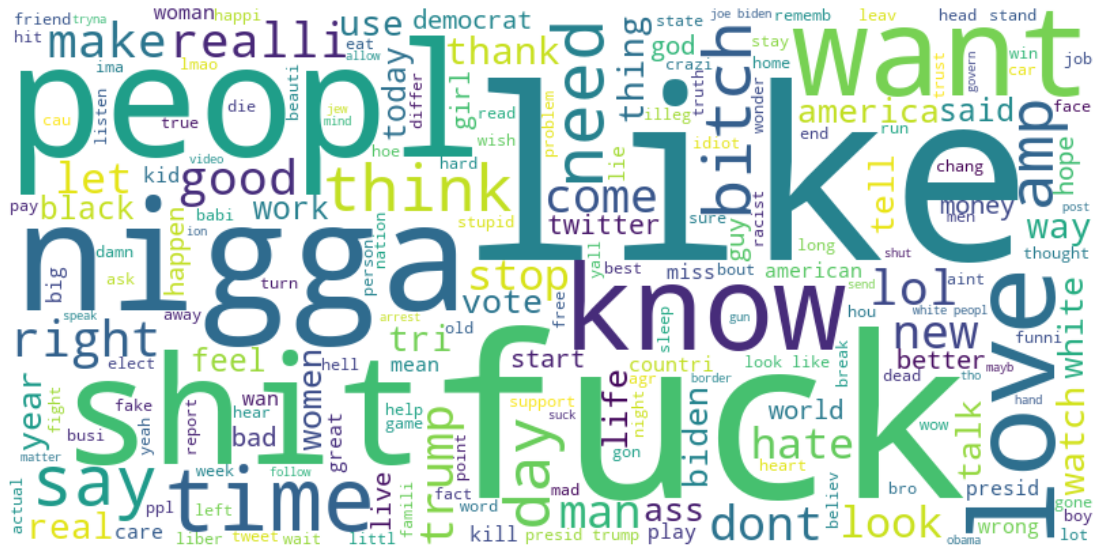

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

# Plot the wordcloud of most common tokens in hate spreader authors
wordcloud = WordCloud(stopwords = stopwords_list, background_color = "white", width = 800, height = 400).generate(" ".join(words))

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Get profan words**

Since we have a list of 200 tweets for each author, each of these texts can be considerable in length, which can affect the execution and the performance of our machine learning algorithms. That is why the idea of **​​selecting the words that are most relevant** in the classification of each author may be interesting. In this case we are facing a problem of classifying hate spreaders, so the **keywords** we are looking for are some kind of **insults**, **swear words**, **derogatory**, **racist** or **homophobic comments**, among others.



For every token in a text, we are going to assign a coefficient between **0 (neutral)** and **1 (bad expression)**, and then we will take only the best *n* words according to their coefficient.

The library `profanity_check` have been used for this purpose: https://pypi.org/project/profanity-check/

In [ ]:
!pip install profanity-check
from profanity_check import predict, predict_prob

In [ ]:
# Select only the top 'max_len' words
max_len = 100

In [ ]:
for i in range(0,len(df)):
  df_tw = pd.DataFrame({'word':df['tweets'][i], 'score':predict_prob(df['tweets'][i])}).sort_values(by=['score'], ascending=False).drop_duplicates().head(max_len)
  df['tweets'][i] = ' '.join(map(str, df_tw['word'].tolist()))
df

,author,label,tweets
0,4d4c5dcbfe38d0d33a0d1b1419952ca8,0,fuck idiot bullshit shit bastard suck moron pi...
1,e30577895cbb4d8f073e4dbb2f3be6d1,0,fuck bitch hoe ass bullshit shit fuckin dumbas...
2,9d08913250938aadcf6c18d0c89a0d14,0,fuck bitch hoe ass shit fuckin nigga piss fuk ...
3,86a7f84c2dd126dac46270b6c912952c,0,fuck suck wtf hell gay mom hate girlfriend les...
4,2a9776a2909ba5e27043faf2d57ba410,0,fuck hoe shit suck nigga dick wtf damn hell fo...
...,...,...,...
195,46df8a13b82d12b2d5f453cc63612298,1,fuck bitch hoe nig shit suck nigga dick wtf he...
196,342a27905d2291b55486c257d77265b4,1,idiot ass bullshit suck moron stupid crap wtf ...
197,f00627537c48b43bf2045b98b3508d94,1,bitch shit suck dickhead stupid piss damn hell...
198,e5cc453c1de4371b8d668c3ab50126f1,1,fuck ass bullshit shit wtf piss goddamn shut r...


# **Train, Validation and Test Sets**

We need to split the whole dataset into training, validation and test sets. The first one will be used to fit the model, the second one will be used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters and the last one will be used to evaluate the performance of the model.

In this case, the proportion of the sets will be:
*   **60%** for training set.
*   **20%** for validation set.
*   **20%** for test set.



In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split 

# Split the whole dataset into train and test sets
tweets_train, tweets_test, label_train, label_test = train_test_split(df['tweets'], df['label'], test_size = 0.2, random_state = 123, stratify = df['label'])
tweets_train, tweets_val, label_train, label_val = train_test_split(tweets_train, label_train, test_size = 0.25, random_state = 123, stratify = label_train)

print('Train dataset size\t', len(tweets_train))
print('Validation dataset size\t', len(tweets_val))
print('Test dataset size\t', len(tweets_test))

Train dataset size	 120
Validation dataset size	 40
Test dataset size	 40


# **BERT (Bidirectional Encoder Representations from Transformers)**

See more about BERT (Bidirectional Encoder Representations from Transformers) here: https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

## **Helper functions**

In [ ]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 16.2 s, sys: 3.17 s, total: 19.4 s
Wall time: 50.4 s


In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

Original source code taken from:
*   https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb
*   https://github.com/ElsaScola/Sarcasm-Detection-with-Natural-Language-Processing-and-Deep-Learning/blob/master/BERT.ipynb

In [ ]:
def bert_encode(texts, tokenizer, max_len):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.TruePositives()])
    
    return model

## **Tokenize text**

In [ ]:
train_input = bert_encode(tweets_train, tokenizer, max_len)
val_input = bert_encode(tweets_val, tokenizer, max_len)
test_input = bert_encode(tweets_test, tokenizer, max_len)

label_train = label_train.astype(np.int64)
label_val = label_val.astype(np.int64)
label_test = label_test.astype(np.int64)

## **Model**

### **Fitting**

In [ ]:
model = build_model(bert_layer, max_len)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Save the model after every epoch.
saveBestModel = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True)
# Stop training when a monitored quantity has stopped improving.
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [ ]:
train_history = model.fit(
    train_input, label_train,
    validation_data = (val_input, label_val),
    epochs = 20,
    batch_size = 8,
    callbacks = [saveBestModel, earlyStopping]
)

Epoch 1/20
15/15 [==============================] - 47s 884ms/step - loss: 0.7749 - accuracy: 0.5083 - precision_3: 0.5308 - recall_3: 0.2396 - true_positives_3: 9.2667 - val_loss: 0.6580 - val_accuracy: 0.6750 - val_precision_3: 0.5402 - val_recall_3: 0.4903 - val_true_positives_3: 35.0000
Epoch 2/20
15/15 [==============================] - 9s 601ms/step - loss: 0.6686 - accuracy: 0.6250 - precision_3: 0.5773 - recall_3: 0.4712 - true_positives_3: 51.8000 - val_loss: 0.6447 - val_accuracy: 0.6000 - val_precision_3: 0.6002 - val_recall_3: 0.4863 - val_true_positives_3: 73.6000
Epoch 3/20
15/15 [==============================] - 9s 606ms/step - loss: 0.6365 - accuracy: 0.5667 - precision_3: 0.5938 - recall_3: 0.5558 - true_positives_3: 108.8667 - val_loss: 0.6483 - val_accuracy: 0.7000 - val_precision_3: 0.5854 - val_recall_3: 0.5927 - val_true_positives_3: 137.0000
Epoch 4/20
15/15 [==============================] - 9s 602ms/step - loss: 0.5994 - accuracy: 0.6917 - precision_3: 0.6070 

### **Evaluation**

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix

In [ ]:
predictions = model.predict(test_input).round().astype(int)

In [ ]:
print('Loss:', metrics.log_loss(label_test, predictions))
print('Accuracy:', metrics.accuracy_score(label_test, predictions))
print('Precision:', metrics.precision_score(label_test, predictions))
print('Recall:', metrics.recall_score(label_test, predictions))
print('f1 score:',metrics.f1_score(label_test, predictions))

print('\n', classification_report(label_test, predictions))

Loss: 14.679259826937606
Accuracy: 0.575
Precision: 0.5483870967741935
Recall: 0.85
f1 score: 0.6666666666666665

               precision    recall  f1-score   support

           0       0.67      0.30      0.41        20
           1       0.55      0.85      0.67        20

    accuracy                           0.57        40
   macro avg       0.61      0.57      0.54        40
weighted avg       0.61      0.57      0.54        40



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

This function called `plot_cm` will be used to better visualize the results of the predictions made in the test set. Source code can be found here: https://www.kaggle.com/agungor2/various-confusion-matrix-plots

In [ ]:
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

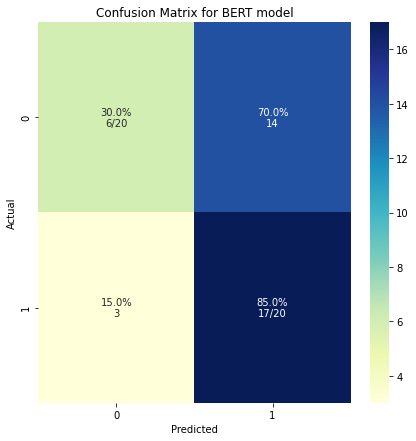

In [ ]:
plot_cm(label_test, predictions, 'Confusion Matrix for BERT model', figsize=(7,7))

# Final predictions

In [ ]:
classification_results = tweets_test.copy(deep = True).to_frame()
classification_results['True label'] = label_test
classification_results['BERT'] = predictions

cols = ['tweets_y', 'True label', 'BERT']
pd.merge(classification_results, df_original, left_index=True, right_index=True)[cols].rename(columns={"tweets_y": "Tweets"})

,Tweets,True label,BERT
105,#USER# The benefits we give all the immigrant...,1,1
59,#USER# Note censors: “Die on own sword” is *f...,0,0
140,Now if my nigga offer to buy everyone drinks ...,1,1
89,#USER# They'll be perfect!!! #USER# You need ...,0,0
43,RT #USER#: January will be BIG for you ! RT #...,0,1
17,it was fun while it but but i gotta gtf home😂...,0,1
135,RT #USER#: 🐶 best of both worlds👶🏽 #URL# #USE...,1,1
165,"RT #USER#: &gt;""Billions in COVID relief for ...",1,0
183,#USER# Where was this at? RT #USER#: Black ma...,1,1
61,"I have 7 new followers from UK., and more las...",0,1
